# Classification of Hypnotic Depth

In [38]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne

import torch
import keras
from pathlib import Path
import re
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy.signal import butter, sosfilt
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit


# helper functions
def preprocess_data(data, baseline_mean):
    # Step 1: Baseline correction (subtract the mean of the first 0.5 seconds for each channel) 
    data_corrected = data - baseline_mean
    
    # Step 2: Robust Scaler (normalize using median and IQR)
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data_corrected.T)
    
    # Step 3: Normalization (z-score normalization)
    normalizer = StandardScaler()
    data_normalized = normalizer.fit_transform(data_scaled).T  # Transpose for sklearn, then back
    
    # Step 4: Clamp values greater than 20 standard deviations (becuause of the normalization at the previous step sd is 1)
    std_threshold = 20
    data_clamped = np.clip(data_normalized, -std_threshold, std_threshold)
    
    return data_clamped

def get_averaged_data(data):
    ''' Average over specific brain areas and return a new dataarray '''
    ba_patches = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5'],
                  'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5', 'FT7'],
                  'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
                  'LO': ['O1', 'PO3'],
                  'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6'],
                  'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6', 'FT8'],
                  'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
                  'RO': ['O2', 'PO4'],
                  'FZ': ['Fz', 'Fpz'],
                  'CZ': ['Cz'],
                  'PZ': ['Pz', 'CPz'],
                  'OZ': ['POz', 'Oz', 'Iz']}
    # average over each brain area patch and save in a new empty dataset
    C, S, T, ses = len(ba_patches), data.sizes.get('subject'), data.sizes.get('time'), 4
    data_numpy = np.zeros([S, ses, C, T])
    for i, (v) in enumerate(ba_patches.values()):
        data_numpy[:, :, i, :] = data.sel(channel=v).mean(dim='channel').values
    return data_numpy, list(ba_patches.keys())

## DATA

In [3]:
EEG_data_path = Path('/Volumes/Extreme SSD/PhD/OTKA study1/EEG data/BIDS/')

all_data = {}

# is it because of the resampling that there are different number of timepoints?

for root in sorted(EEG_data_path.glob('sub-*')):
    sub_path  = root / 'ses-01/eeg/'
    for data_path in sorted(sub_path.glob('*_eeg.vhdr')):
        bids_id, task = re.match(r'.*/sub-(.*)_ses-01_task-(.*)_eeg.vhdr', str(data_path)).groups()
        if task == 'baseline1':
            print(f'>>>>>>Processing {bids_id} {task}')
            epoch = mne.io.read_raw_brainvision(data_path, verbose=False, eog=['EOG1', 'EOG2'], misc=['ECG'])
            epoch.pick(picks='eeg', exclude=['M1', 'M2'])
            epoch.resample(128)
            epoch = epoch.get_data()
            baseline_mean = epoch.mean(axis=1, keepdims=True)
            continue
    
        if task.__contains__('experience'):
            print(f'>>>>>>Processing {bids_id} {task}')
            epoch = mne.io.read_raw_brainvision(data_path, verbose=False, eog=['EOG1', 'EOG2'], misc=['ECG'])
            epoch.pick(picks='eeg', exclude=['M1', 'M2'])
            epoch.resample(128)
            data = epoch.get_data()
            data_clamped = preprocess_data(data, baseline_mean)
            all_data[f'sub-{bids_id}_{task}'] = data_clamped

In [142]:
## Prepare the data to be converted and stored as a data array

# trim all the data in the dictionary to the minimum length
min_len = min([i.shape[1] for i in list(all_data.values())])
all_data = {k: v[:, :min_len] for k, v in all_data.items()}

# there are two missing tasks for sub-52, we fill them with zeros so th
all_data['sub-52_experience2'] = np.zeros_like(all_data['sub-52_experience1'])
all_data['sub-52_experience3'] = np.zeros_like(all_data['sub-52_experience1'])
data = np.array(list(all_data.values()))
data = data.reshape(52, 4, 56, -1)  # 52 subjects, 4 conditions, 56 channels, time
# rearranging the data for the last participant whose experience 2 and 3 data is missing
data[-1, -1] = data[-1, -3]  
data[-1, -3] = data[-1, -2]

data = xr.DataArray(data, 
                    dims=('subject', 'tasks', 'channel', 'time'),
                    coords={'subject': np.unique([i.split('_')[0] for i in all_data.keys()]),
                            'tasks': ['experience1', 'experience2', 'experience3', 'experience4'],
                            'channel': epoch.ch_names,
                            'time': np.arange(min_len)}
                            )

# data.to_netcdf('/Users/yeganeh/Codes/otka_data/EEG/experiment_EEG_data.nc5', engine='h5netcdf')

## Xy

In [2]:
# open EEG data
EEG_data = xr.open_dataarray('/Users/yeganeh/Codes/otka_data/EEG/experiment_EEG_data.nc5')
only_real_hypnosis = False

# open session data
session_data = pd.read_csv('/Users/yeganeh/Codes/otka_data/behavioral/behavioral_data.csv')
described_as_hyp = session_data.query('description == "hypnosis"')[['bids_id', 'session', 'score', 'procedure']].set_index('bids_id')
n_sessions = 2
if only_real_hypnosis:
    described_as_hyp = described_as_hyp.query('procedure in ["relaxation", "confusion"]')
    n_sessions = 1

In [74]:
n_subject = 51
time_dim = 512
filtering = True
channels = ['Oz', 'Fz', 'Cz', 'Pz', 'Fp1', 'Fp2', 'F1', 'F2']
average_over_channels = True

if average_over_channels:
    EEG_data = EEG_data.sel(subject=EEG_data.subject[:n_subject])
    X_input, channels = get_averaged_data(EEG_data)
else:
    X_input = EEG_data.sel(subject=EEG_data.subject[:n_subject], channel=channels).to_numpy()

# including only hypnosis sessions
X_input_hyp =  np.zeros([n_subject, n_sessions, len(channels), X_input.shape[-1]])
for i in range(X_input.shape[0]):
    ses = described_as_hyp.loc[i+1, 'session'].values - 1
    X_input_hyp[i] = X_input[i, ses, :, :]

# preparing x
if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    X_input_hyp = sosfilt(sos, X_input_hyp, axis=-1)

X_input_hyp = torch.tensor(X_input_hyp.squeeze()).unfold(-1, time_dim, time_dim).permute(0, 1, 3, 4, 2).flatten(0, 1)

# prepare y
described_as_hyp['binary_scores'] = described_as_hyp['score'].apply(lambda x: 0 if x>6 else 1)
y = described_as_hyp.loc[:n_subject, 'binary_scores']
groups = y.index.to_numpy() - 1  # -1 because the bids_id are not zero based unlike the indices
y = y.values

In [86]:
# prepare Kfold cross validation
cross_val = True

if cross_val:
    n_splits = 4
    group_kfold = StratifiedGroupKFold(n_splits=n_splits)
    train_val_splits = []
    for train_idx, val_idx in group_kfold.split(X_input_hyp, y, groups=groups):
        train_val_splits.append((train_idx, val_idx))

    # make sure that the splits are stratified and ther is a balance between the classes
    for train_idx, val_idx in train_val_splits:
        print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

else:
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)  # random state == 9
    train_idx, val_idx = next(group_shuffle.split(X_input_hyp, y, groups=groups))
    print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

[0.46052632 0.53947368] [0.5 0.5]
[0.47368421 0.52631579] [0.46153846 0.53846154]
[0.47368421 0.52631579] [0.46153846 0.53846154]
[0.47435897 0.52564103] [0.45833333 0.54166667]


In [76]:
y = torch.tensor(y).reshape(-1, 1).repeat(1, X_input_hyp.shape[1])

## MODEL

In [77]:
# model
from src.EEGModalNet.models.common import ResidualBlock
import keras
from keras import layers
from keras import regularizers
l2_lambda = 0.01
dropout_rate = 0.2

class Critic(keras.Model):
    def __init__(self, time_dim, feature_dim, use_sublayer):
        super(Critic, self).__init__()

        self.input_shape = (time_dim, feature_dim)
        self.use_sublayer = use_sublayer

        self.model = keras.Sequential([
            keras.Input(shape=self.input_shape),
            ResidualBlock(feature_dim * 4, 5, activation='relu'),
            layers.Conv1D(2, 5, padding='same', activation='relu', name='conv3', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Conv1D(1, 5, padding='same', activation='relu', name='conv4', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, name='dis_dense1', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(128, name='dis_dense2', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(32, name='dis_dense3', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(8, name='dis_dense4', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(1, name='sigmoid', activation='sigmoid', kernel_regularizer=regularizers.L2(l2_lambda))
        ], name='critic')
    
    def call(self, inputs):
        return self.model(inputs)

def build_model():
    model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [81]:
n_epochs = 20
if cross_val:
    all_val_acc = []
    all_acc = []
    all_loss = []
    all_val_loss = []

    for i in range(n_splits):
        print(f'>>>>>> Fold {i+1}')
        model = build_model()
        train_idx, val_idx = train_val_splits[i]
        history = model.fit(X_input_hyp[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                            epochs=n_epochs,
                            batch_size=64,
                            validation_data=(X_input_hyp[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

        all_val_acc.append(history.history['val_accuracy'])
        all_acc.append(history.history['accuracy'])
        all_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

        # # save the model
        # model.save(f'data/trainings/training_19092024/cv/model_{i+1}.model.keras')

else:
    # model = build_model()
    history = model.fit(X_input_hyp[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                        epochs=n_epochs,
                        batch_size=64,
                        validation_data=(X_input_hyp[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9096 - loss: 0.3104 - val_accuracy: 0.7649 - val_loss: 0.5762
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9204 - loss: 0.2885 - val_accuracy: 0.7430 - val_loss: 0.5981
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9192 - loss: 0.2904 - val_accuracy: 0.7666 - val_loss: 0.5710
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9207 - loss: 0.2832 - val_accuracy: 0.7732 - val_loss: 0.5657
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9373 - loss: 0.2504 - val_accuracy: 0.7286 - val_loss: 0.6544
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9387 - loss: 0.2523 - val_accuracy: 0.7605 - val_loss: 0.6072
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9499 - loss: 0.2241 - val_accuracy: 0.6691 - val_loss: 0.7677
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9442 - loss: 0.2361 - val_accu

In [67]:
y_pred = model.predict(X_input_hyp[val_idx].flatten(0, 1))
y_pred = y_pred > 0.5
y_pred = y_pred.astype(int)
all(y_pred.squeeze() == y[val_idx].flatten(0, 1))

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


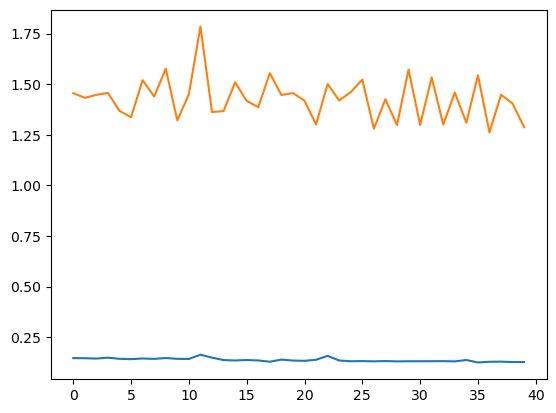

In [34]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

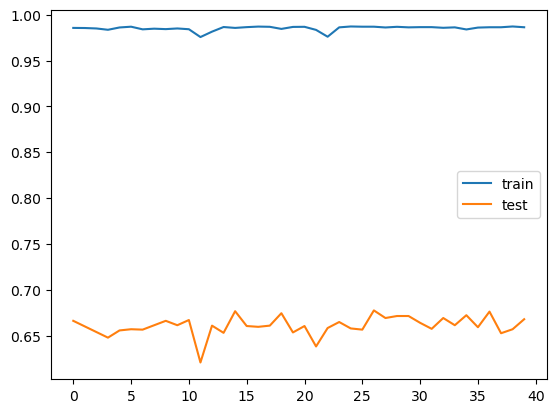

In [35]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

In [37]:
# save model & model config
model_path = 'data/trainings/training_19092024/'
model_name = 'HD_classify_'+ '8_channels'
model.save(model_path+f'{model_name}.model.keras')
model_config = model.model.get_config()
import json
with open(f'{model_name}_config.json', 'w') as f:
    json.dump(model_config, f)

In [123]:
# results
df = pd.read_csv('logs/history.csv', index_col=0)
df2 = pd.read_csv('logs/history_last3folds.csv', index_col=0).iloc[300:600]

df = df.drop(df.index[-1000:])

df_new = pd.DataFrame()

for i in range(3):
    df_new = pd.concat([df_new, df.iloc[i*500:i*500+300]], axis=0)

df_new = pd.concat([df_new, df2], axis=0).reset_index(drop=True)

Text(0.5, 1.0, 'Cross-Validated Accuracy Distribution')

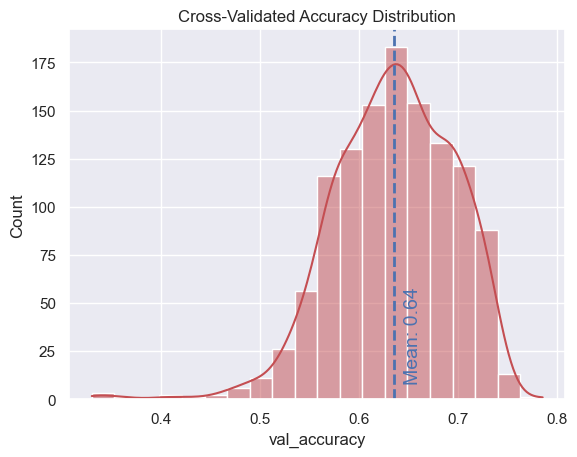

In [141]:
import seaborn as sns
sns.set_theme(style='darkgrid')
sns.histplot(df_new['val_accuracy'], bins=20, kde=True, color='r', label='Validation Accuracy')
# plot a vertical line at the mean.
plt.axvline(df_new['val_accuracy'].mean(), color='b', linestyle='dashed', linewidth=2)
# add the mean value to the plot.
plt.text(df_new['val_accuracy'].mean() + 0.01, 10, f'Mean: {df_new["val_accuracy"].mean():.2f}', rotation=90, color='b', fontsize=14)
plt.title('Cross-Validated Accuracy Distribution')

## Interpretablity Techniques

In [11]:
# open model
model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False)
model.load_weights('logs/model_2.model.keras')

In [42]:
import numpy as np
import torch
from torch.autograd import grad

# Integrated Gradients function
def integrated_gradients(model, inputs, target_class, baseline=None, steps=50):
    if baseline is None:
        # Set the baseline to zero (same shape as input)
        baseline = torch.zeros_like(inputs)
    
    # Scale inputs and compute gradients at each interpolation point
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(steps + 1)]
    scaled_inputs = torch.stack(scaled_inputs).flatten(0, 1).requires_grad_(True)
    
    # Initialize attributions
    total_gradients = torch.zeros_like(inputs)
    
    for scaled_input in scaled_inputs:
        # Perform forward pass
        output = model(scaled_input.unsqueeze(0))  # Add batch dimension
        target = output[:, target_class]  # Extract the logit for the target class
        
        # Compute gradients
        grads = grad(target, scaled_input, retain_graph=True)[0]
        total_gradients += grads
    
    # Average gradients over all steps
    avg_gradients = total_gradients / steps
    
    # Compute the attributions
    attributions = (inputs - baseline) * avg_gradients
    return attributions.detach().cpu().numpy()


In [28]:
sample_idx = 0
eeg_sample = torch.tensor(X_input_hyp[train_ids].flatten(0, 1)[sample_idx], dtype=torch.float32).unsqueeze(0) 
eeg_sample.shape

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_69344/1547276079.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eeg_sample = torch.tensor(X_input_hyp[train_ids].flatten(0, 1)[sample_idx], dtype=torch.float32).unsqueeze(0)


torch.Size([1, 512, 8])

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_69344/3518009999.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eeg_sample = torch.tensor(X_input_hyp[test_ids].flatten(0, 1)[sample_idx], dtype=torch.float32).unsqueeze(0)  # Add batch dimension


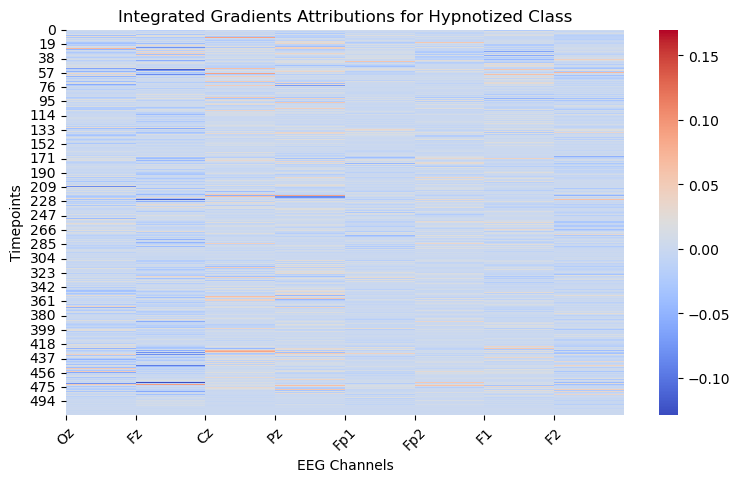

In [64]:
# Load the Keras model
model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False)
model.load_weights('logs/model_2.model.keras')


# Select a sample from your test data
sample_idx = 0
eeg_sample = torch.tensor(X_input_hyp[test_ids].flatten(0, 1)[sample_idx], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Call Integrated Gradients function
attributions = integrated_gradients(model, eeg_sample, target_class=0)  # Assuming 1 is the hypnotized class

# Visualize or interpret the attributions as needed
import matplotlib.pyplot as plt
import seaborn as sns

# Example of visualizing the attributions as a heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(attributions.squeeze(), cmap='coolwarm', cbar=True)
plt.title('Integrated Gradients Attributions for Hypnotized Class')
plt.xlabel('EEG Channels')

# include the channels labels in the x-axis
plt.xticks(ticks=np.arange(len(channels)), labels=channels, rotation=45)
plt.ylabel('Timepoints')
plt.show()


In [ ]:
test_set = X_input_hyp[test_ids].flatten(0, 1)
all_attributions = []

for sample in test_set[:10]:  # Loop over all EEG samples
    attributions = integrated_gradients(model, sample, target_class=0)  # Get attributions for each sample
    all_attributions.append(attributions)

# Convert the list to a NumPy array for easier averaging
all_attributions = np.array(all_attributions)

# Average attributions over all samples
avg_attributions = np.mean(all_attributions, axis=0)

## Gender Classification Using OTKA data

In [41]:
# gender data (y)
one_hot_encoding = False

gender = pd.read_excel('/Users/yeganeh/Codes/SugNet/data/PLB_HYP_data_MASTER.xlsx')[['bids_id', 'gender']].dropna().set_index('bids_id')
gender['gender'] = gender['gender'].apply(lambda x: 1 if x == 'Female' else 0)
y_ = gender['gender'].values.repeat(4)[:-2]  # repeat for the 4 sessions and remove the last two entries because the last two sessions are missing for the last participant

# subject ids for grouped cross validation
groups = gender.index.to_numpy() - 1
groups = groups.repeat(4)[:-2]

In [74]:
# X
EEG_data = xr.open_dataarray('data/OTKA/experiment_EEG_data.nc5')

n_subject = 52
time_dim = 512
filtering = True
average_channels = True
channels = ['Oz', 'Fz', 'Cz', 'Pz', 'Fp1', 'Fp2', 'F1', 'F2']

if average_channels:
    X_input, channels = get_averaged_data(EEG_data)
else:
    X_input = EEG_data.sel(subject=EEG_data.subject[:n_subject], channel=channels).to_numpy()

# remove placeholder data (zeros) from the missing sessions of the last participant 
X_input = torch.tensor(X_input).flatten(0, 1)
X_sub52_ses4 = X_input[-1].unsqueeze(0)
X_input = X_input[:-3]
X_input = torch.cat([X_input, X_sub52_ses4], dim=0)

# preparing x
if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    X_input = sosfilt(sos, np.array(X_input), axis=-1)

X_input = torch.tensor(X_input).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1)

In [86]:
# # one hot encoding of the gender data
if one_hot_encoding:
    y = np.eye(2)[y_].astype(int)
    y = torch.tensor(y).reshape(-1, 1, 2).repeat(1, X_input.shape[1], 1)
else:
    y = torch.tensor(y_).reshape(-1, 1).repeat(1, X_input.shape[1])

In [87]:
# Train/test split
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
cross_val = False

if cross_val:
    n_splits = 3
    group_kfold = StratifiedGroupKFold(n_splits=n_splits)
    train_val_splits = []
    for train_idx, val_idx in group_kfold.split(np.array(X_input), y_, groups=groups):
        train_val_splits.append((train_idx, val_idx))
else:
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=2)  
    train_idx, val_idx = next(group_shuffle.split(np.array(X_input), y_, groups=groups))

np.unique(y[train_idx].flatten(0, 1), return_counts=True)[1] / len(y[train_idx].flatten(0, 1)), np.unique(y[val_idx].flatten(0, 1), return_counts=True)[1] / len(y[val_idx].flatten(0, 1))

(array([0.2345679, 0.7654321]), array([0.27272727, 0.72727273]))

### model

In [93]:
# model
from src.EEGModalNet.models.common import ResidualBlock
import keras
from keras import layers
from keras import regularizers
l2_lambda = 0.01
dropout_rate = 0.5

class Critic(keras.Model):
    def __init__(self, time_dim, feature_dim, use_sublayer):
        super(Critic, self).__init__()

        self.input_shape = (time_dim, feature_dim)
        self.use_sublayer = use_sublayer

        self.model = keras.Sequential([
            keras.Input(shape=self.input_shape),
            ResidualBlock(feature_dim * 4, 5, activation='relu'),
            layers.Conv1D(2, 5, padding='same', activation='relu', name='conv3', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Conv1D(1, 5, padding='same', activation='relu', name='conv4', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, name='dis_dense1', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(128, name='dis_dense2', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(32, name='dis_dense3', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(8, name='dis_dense4', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(1, name='sigmoid', activation='sigmoid', kernel_regularizer=regularizers.L2(l2_lambda))
        ], name='critic')
    
    def call(self, inputs):
        return self.model(inputs)

def build_model():
    model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
if cross_val:
    k = 3
    n_epochs = 3
    all_val_acc = []
    all_acc = []
    all_loss = []
    all_val_loss = []

    for i in range(k):
        print(f'>>>>>> Fold {i+1}')
        model = build_model()
        train_idx, val_idx = train_val_splits[i]
        history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                            epochs=n_epochs,
                            batch_size=64,
                            validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

        all_val_acc.append(history.history['val_accuracy'])
        all_acc.append(history.history['accuracy'])
        all_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

else:
    model = build_model()
    history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))